In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from datetime import datetime, timedelta
import json

In [3]:
!pip install -q  evidently plotly streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.8/237.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0

In [18]:
!pip install -q evidently
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from evidently.report import Report, ColumnMapping
from evidently.metric_preset import (
    DataDriftPreset,
    TargetDriftPreset,
    ClassificationPreset
)
from evidently.metrics import *

# Visualisation interactive
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

ModuleNotFoundError: No module named 'evidently.report'

In [5]:
with open('best_model_lgbm.pkl', 'rb') as f:
    model = pickle.load(f)

with open('model_config.pkl', 'rb') as f:
    config = pickle.load(f)

with open('preprocessing_pipeline.pkl', 'rb') as f:
    preprocessing_pipeline = pickle.load(f)

print(f"   Modèle: {config['model_name']}")
print(f"   Seuil optimal: {config['optimal_threshold']}")
print(f"   Nombre de features: {len(config['features'])}")

   Modèle: LightGBM
   Seuil optimal: 0.08
   Nombre de features: 58


In [6]:
X_reference = pd.read_csv('X_test_monitoring.csv')
y_reference = pd.read_csv('y_test_monitoring.csv').values.ravel()
y_proba_reference = pd.read_csv('y_proba_test.csv').values.ravel()


In [7]:
def simulate_production_data(X_reference, drift_level=0.0, n_samples=1000):
    """
    Simule des données de production avec un niveau de drift contrôlé

    drift_level: 0.0 = pas de drift, 1.0 = drift maximum
    """
    np.random.seed(42)

    # Échantillonner depuis les données de référence
    indices = np.random.choice(len(X_reference), n_samples, replace=True)
    X_prod = X_reference.iloc[indices].copy().reset_index(drop=True)

    if drift_level > 0:
        # Introduire du drift sur certaines features
        n_features_drift = max(1, int(len(X_prod.columns) * 0.3))
        drift_features = np.random.choice(X_prod.columns, n_features_drift, replace=False)

        for feat in drift_features:
            # Shift de la moyenne
            shift = drift_level * X_prod[feat].std() * np.random.choice([-1, 1])
            X_prod[feat] = X_prod[feat] + shift

            # Ajout de bruit
            noise = np.random.normal(0, drift_level * X_prod[feat].std() * 0.5, len(X_prod))
            X_prod[feat] = X_prod[feat] + noise

    return X_prod

In [8]:
production_batches = {
    'Week 1': simulate_production_data(X_reference, drift_level=0.0, n_samples=500),
    'Week 2': simulate_production_data(X_reference, drift_level=0.1, n_samples=500),
    'Week 3': simulate_production_data(X_reference, drift_level=0.2, n_samples=500),
    'Week 4': simulate_production_data(X_reference, drift_level=0.4, n_samples=500),
}

for week, data in production_batches.items():
    print(f"   {week}: {len(data)} samples")


   Week 1: 500 samples
   Week 2: 500 samples
   Week 3: 500 samples
   Week 4: 500 samples


In [9]:
class CreditRiskMonitor:
    """
    Framework de monitoring pour modèles de risque de crédit
    """

    def __init__(self, model, config, reference_data, reference_labels):
        self.model = model
        self.config = config
        self.reference_data = reference_data
        self.reference_labels = reference_labels
        self.threshold = config['optimal_threshold']
        self.monitoring_history = []

        # Calculer les métriques de référence
        self.reference_proba = model.predict_proba(reference_data)[:, 1]
        self.reference_pred = (self.reference_proba >= self.threshold).astype(int)

        self.reference_metrics = self._calculate_metrics(
            reference_labels, self.reference_pred, self.reference_proba
        )

        print(" Monitor initialisé")
        print(f"   Métriques de référence:")
        for k, v in self.reference_metrics.items():
            print(f"      {k}: {v:.4f}")

    def _calculate_metrics(self, y_true, y_pred, y_proba):
        """Calcule toutes les métriques de performance"""
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1_score': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else 0
        }

    def predict(self, X):
        """Prédiction avec le seuil optimal"""
        proba = self.model.predict_proba(X)[:, 1]
        pred = (proba >= self.threshold).astype(int)
        return pred, proba

    def monitor_batch(self, X_batch, y_batch=None, batch_name="batch"):
        """
        Monitore un batch de données de production
        """
        # Prédictions
        y_pred, y_proba = self.predict(X_batch)

        # Métriques de performance (si labels disponibles)
        metrics = {}
        if y_batch is not None:
            metrics = self._calculate_metrics(y_batch, y_pred, y_proba)

        # Statistiques des prédictions
        pred_stats = {
            'n_samples': len(X_batch),
            'high_risk_rate': y_pred.mean(),
            'avg_risk_score': y_proba.mean(),
            'std_risk_score': y_proba.std(),
            'high_confidence_rate': ((y_proba > 0.8) | (y_proba < 0.2)).mean()
        }

        # Data drift (comparaison avec référence)
        drift_scores = self._calculate_drift(X_batch)

        # Résultat
        result = {
            'batch_name': batch_name,
            'timestamp': datetime.now().isoformat(),
            'metrics': metrics,
            'pred_stats': pred_stats,
            'drift_scores': drift_scores,
            'alerts': self._check_alerts(metrics, pred_stats, drift_scores)
        }

        self.monitoring_history.append(result)

        return result

    def _calculate_drift(self, X_batch):
        """Calcule le drift pour chaque feature"""
        drift_scores = {}

        for col in X_batch.columns:
            ref_mean = self.reference_data[col].mean()
            ref_std = self.reference_data[col].std()
            batch_mean = X_batch[col].mean()

            # PSI simplifié (Population Stability Index)
            if ref_std > 0:
                drift_scores[col] = abs(batch_mean - ref_mean) / ref_std
            else:
                drift_scores[col] = 0

        return drift_scores

    def _check_alerts(self, metrics, pred_stats, drift_scores):
        """Vérifie les conditions d'alerte"""
        alerts = []

        # Alerte performance
        if metrics:
            if metrics.get('f1_score', 1) < self.reference_metrics['f1_score'] * 0.8:
                alerts.append({
                    'type': 'PERFORMANCE_DROP',
                    'severity': 'HIGH',
                    'message': f"F1-Score dropped below 80% of reference"
                })

            if metrics.get('recall', 1) < 0.5:
                alerts.append({
                    'type': 'LOW_RECALL',
                    'severity': 'CRITICAL',
                    'message': f"Recall below 50% - missing high risk customers!"
                })

        # Alerte prédictions
        ref_high_risk_rate = self.reference_pred.mean()
        if abs(pred_stats['high_risk_rate'] - ref_high_risk_rate) > 0.1:
            alerts.append({
                'type': 'PREDICTION_DRIFT',
                'severity': 'MEDIUM',
                'message': f"High risk rate changed significantly"
            })

        # Alerte data drift
        high_drift_features = [f for f, score in drift_scores.items() if score > 1.0]
        if len(high_drift_features) > len(drift_scores) * 0.3:
            alerts.append({
                'type': 'DATA_DRIFT',
                'severity': 'HIGH',
                'message': f"{len(high_drift_features)} features with significant drift"
            })

        return alerts

    def get_monitoring_report(self):
        """Génère un rapport de monitoring"""
        if not self.monitoring_history:
            return "No monitoring data available"

        report = []
        report.append("=" * 60)
        report.append(" MONITORING REPORT - Credit Risk Model")
        report.append("=" * 60)

        for entry in self.monitoring_history:
            report.append(f"\n {entry['batch_name']} ({entry['timestamp'][:10]})")
            report.append(f"   Samples: {entry['pred_stats']['n_samples']}")
            report.append(f"   High Risk Rate: {entry['pred_stats']['high_risk_rate']:.2%}")
            report.append(f"   Avg Risk Score: {entry['pred_stats']['avg_risk_score']:.4f}")

            if entry['metrics']:
                report.append(f"   F1-Score: {entry['metrics']['f1_score']:.4f}")
                report.append(f"   Recall: {entry['metrics']['recall']:.4f}")

            if entry['alerts']:
                report.append(f"    ALERTS: {len(entry['alerts'])}")
                for alert in entry['alerts']:
                    report.append(f"      [{alert['severity']}] {alert['message']}")

        return "\n".join(report)

In [10]:
monitor = CreditRiskMonitor(
    model=model,
    config=config,
    reference_data=X_reference,
    reference_labels=y_reference
)

 Monitor initialisé
   Métriques de référence:
      accuracy: 0.5911
      precision: 0.2626
      recall: 0.5778
      f1_score: 0.3611
      roc_auc: 0.6246


In [11]:
print("\n🔄 Monitoring des batches de production...\n")

for week, X_batch in production_batches.items():
    # Simuler des labels (en production, on les aurait après un délai)
    y_batch_true = np.random.binomial(1, 0.12, len(X_batch))  # ~12% high risk

    result = monitor.monitor_batch(X_batch, y_batch_true, batch_name=week)

    print(f" {week}:")
    print(f"   High Risk Rate: {result['pred_stats']['high_risk_rate']:.2%}")
    print(f"   Avg Risk Score: {result['pred_stats']['avg_risk_score']:.4f}")
    if result['alerts']:
        for alert in result['alerts']:
            print(f"    [{alert['severity']}] {alert['message']}")
    print()


🔄 Monitoring des batches de production...

 Week 1:
   High Risk Rate: 43.60%
   Avg Risk Score: 0.1869
    [HIGH] F1-Score dropped below 80% of reference
    [CRITICAL] Recall below 50% - missing high risk customers!

 Week 2:
   High Risk Rate: 37.00%
   Avg Risk Score: 0.1661
    [HIGH] F1-Score dropped below 80% of reference
    [CRITICAL] Recall below 50% - missing high risk customers!

 Week 3:
   High Risk Rate: 37.00%
   Avg Risk Score: 0.1667
    [HIGH] F1-Score dropped below 80% of reference
    [CRITICAL] Recall below 50% - missing high risk customers!

 Week 4:
   High Risk Rate: 45.80%
   Avg Risk Score: 0.1930
    [HIGH] F1-Score dropped below 80% of reference



In [12]:
print(monitor.get_monitoring_report())


 MONITORING REPORT - Credit Risk Model

 Week 1 (2025-11-22)
   Samples: 500
   High Risk Rate: 43.60%
   Avg Risk Score: 0.1869
   F1-Score: 0.1434
   Recall: 0.3279
    ALERTS: 2
      [HIGH] F1-Score dropped below 80% of reference
      [CRITICAL] Recall below 50% - missing high risk customers!

 Week 2 (2025-11-22)
   Samples: 500
   High Risk Rate: 37.00%
   Avg Risk Score: 0.1661
   F1-Score: 0.1953
   Recall: 0.3521
    ALERTS: 2
      [HIGH] F1-Score dropped below 80% of reference
      [CRITICAL] Recall below 50% - missing high risk customers!

 Week 3 (2025-11-22)
   Samples: 500
   High Risk Rate: 37.00%
   Avg Risk Score: 0.1667
   F1-Score: 0.1885
   Recall: 0.3898
    ALERTS: 2
      [HIGH] F1-Score dropped below 80% of reference
      [CRITICAL] Recall below 50% - missing high risk customers!

 Week 4 (2025-11-22)
   Samples: 500
   High Risk Rate: 45.80%
   Avg Risk Score: 0.1930
   F1-Score: 0.2276
   Recall: 0.5410
    ALERTS: 1
      [HIGH] F1-Score dropped below 80%

In [13]:
history_df = pd.DataFrame([
    {
        'batch': h['batch_name'],
        'high_risk_rate': h['pred_stats']['high_risk_rate'],
        'avg_risk_score': h['pred_stats']['avg_risk_score'],
        'n_alerts': len(h['alerts']),
        **{f"drift_{k}": v for k, v in list(h['drift_scores'].items())[:5]}
    }
    for h in monitor.monitoring_history
])

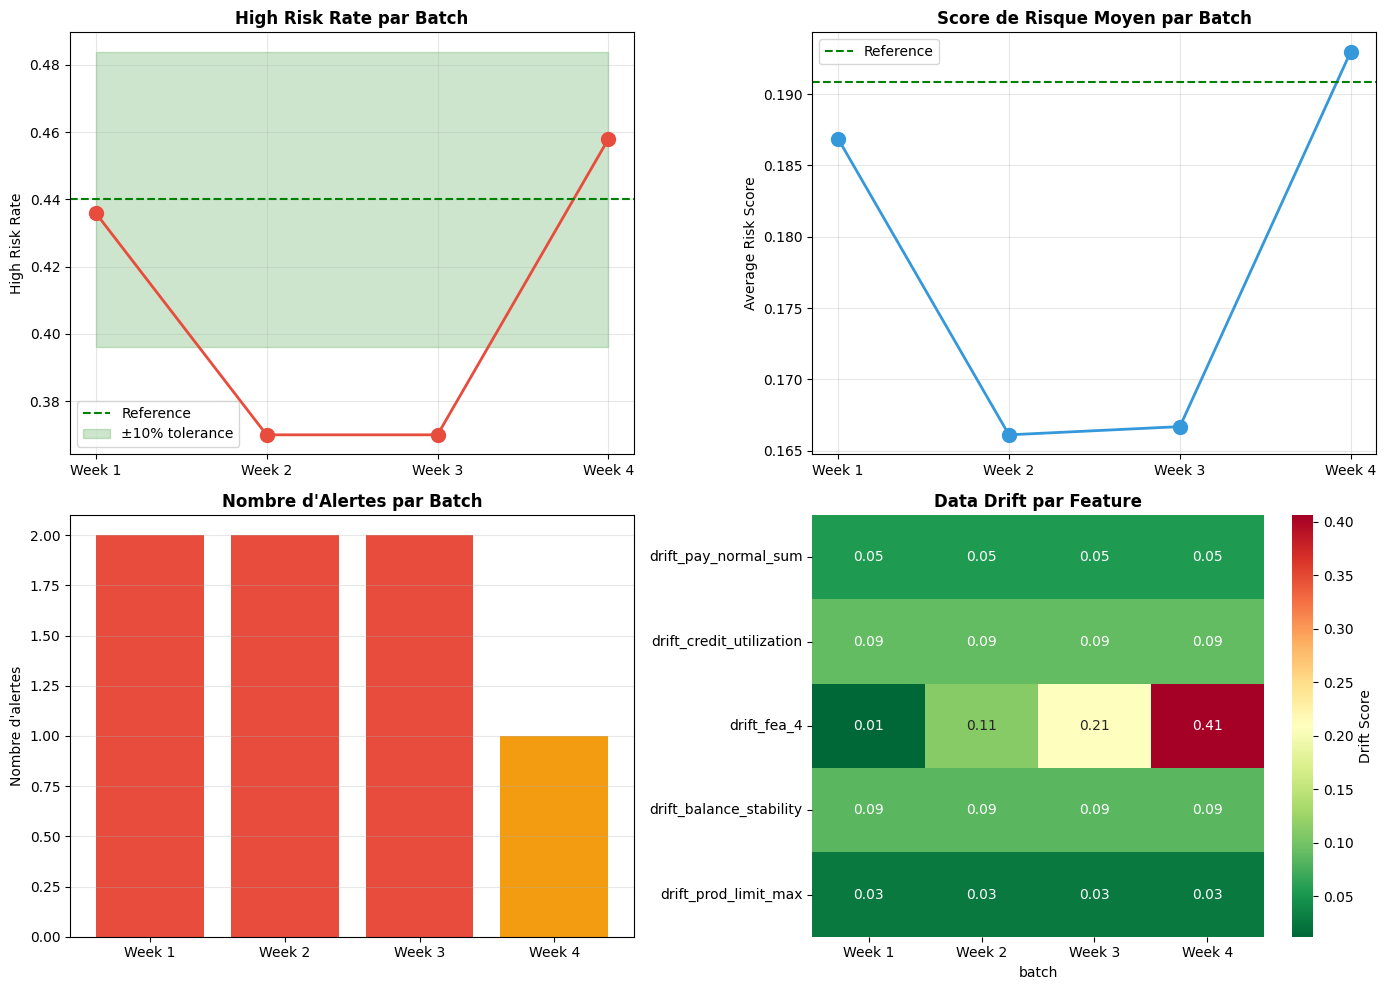

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# High Risk Rate over time
axes[0, 0].plot(history_df['batch'], history_df['high_risk_rate'], 'o-',
                linewidth=2, markersize=10, color='#e74c3c')
axes[0, 0].axhline(y=monitor.reference_pred.mean(), color='green',
                   linestyle='--', label='Reference')
axes[0, 0].fill_between(history_df['batch'],
                        monitor.reference_pred.mean() * 0.9,
                        monitor.reference_pred.mean() * 1.1,
                        alpha=0.2, color='green', label='±10% tolerance')
axes[0, 0].set_title('High Risk Rate par Batch', fontsize=12, weight='bold')
axes[0, 0].set_ylabel('High Risk Rate')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Average Risk Score
axes[0, 1].plot(history_df['batch'], history_df['avg_risk_score'], 'o-',
                linewidth=2, markersize=10, color='#3498db')
axes[0, 1].axhline(y=monitor.reference_proba.mean(), color='green',
                   linestyle='--', label='Reference')
axes[0, 1].set_title('Score de Risque Moyen par Batch', fontsize=12, weight='bold')
axes[0, 1].set_ylabel('Average Risk Score')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Number of Alerts
colors = ['#2ecc71' if x == 0 else '#f39c12' if x < 2 else '#e74c3c'
          for x in history_df['n_alerts']]
axes[1, 0].bar(history_df['batch'], history_df['n_alerts'], color=colors)
axes[1, 0].set_title('Nombre d\'Alertes par Batch', fontsize=12, weight='bold')
axes[1, 0].set_ylabel('Nombre d\'alertes')
axes[1, 0].grid(axis='y', alpha=0.3)

# Drift heatmap (top features)
drift_cols = [c for c in history_df.columns if c.startswith('drift_')]
if drift_cols:
    drift_data = history_df[drift_cols].T
    drift_data.columns = history_df['batch']
    sns.heatmap(drift_data, annot=True, fmt='.2f', cmap='RdYlGn_r',
                ax=axes[1, 1], cbar_kws={'label': 'Drift Score'})
    axes[1, 1].set_title('Data Drift par Feature', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

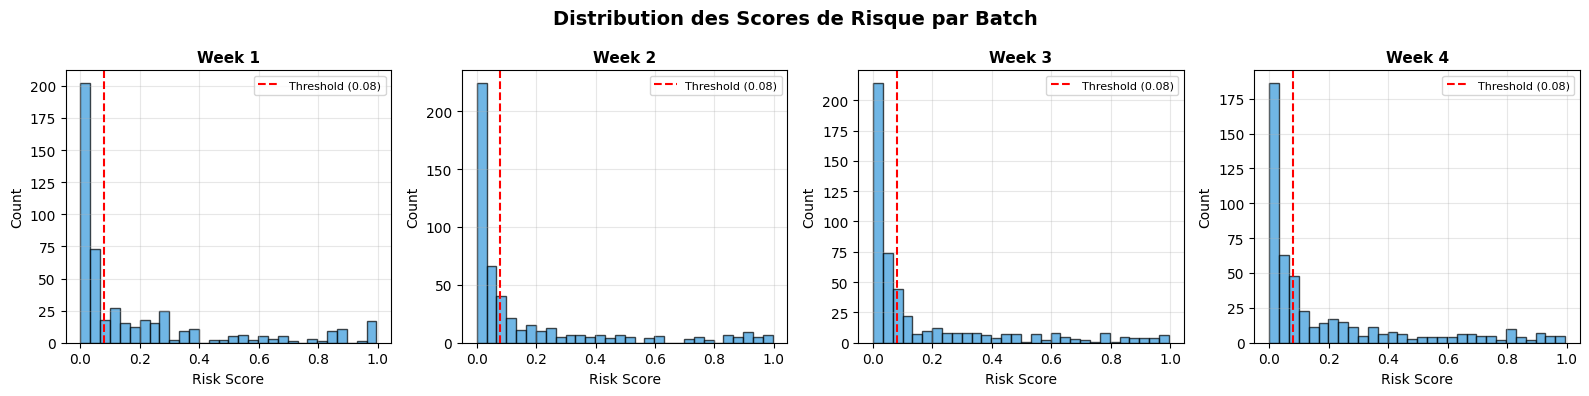

In [15]:
fig, axes = plt.subplots(1, len(production_batches), figsize=(16, 4))

for idx, (week, X_batch) in enumerate(production_batches.items()):
    _, y_proba = monitor.predict(X_batch)

    axes[idx].hist(y_proba, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=monitor.threshold, color='red', linestyle='--',
                      label=f'Threshold ({monitor.threshold})')
    axes[idx].set_title(f'{week}', fontsize=11, weight='bold')
    axes[idx].set_xlabel('Risk Score')
    axes[idx].set_ylabel('Count')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.suptitle('Distribution des Scores de Risque par Batch', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

Référence vs dernière semaine (avec le plus de drift)

In [20]:
drift_analysis = []

for col in X_reference.columns:
    ref_mean = X_reference[col].mean()
    ref_std = X_reference[col].std()
    ref_median = X_reference[col].median()

    curr_mean = production_batches['Week 4'][col].mean()
    curr_std = production_batches['Week 4'][col].std()
    curr_median = production_batches['Week 4'][col].median()

    drift_score = abs(curr_mean - ref_mean) / (ref_std + 1e-10)

    # Test de Kolmogorov-Smirnov pour comparer les distributions
    from scipy.stats import ks_2samp
    ks_stat, ks_pvalue = ks_2samp(X_reference[col], production_batches['Week 4'][col])

    drift_analysis.append({
        'Feature': col,
        'Ref_Mean': ref_mean,
        'Curr_Mean': curr_mean,
        'Mean_Change_%': ((curr_mean - ref_mean) / (abs(ref_mean) + 1e-10)) * 100,
        'Drift_Score': drift_score,
        'KS_Statistic': ks_stat,
        'KS_p_value': ks_pvalue,
        'Drift_Detected': 'YES' if (drift_score > 0.5 or ks_pvalue < 0.05) else 'NO'
    })

drift_df = pd.DataFrame(drift_analysis).sort_values('Drift_Score', ascending=False)


In [21]:
drift_detected = drift_df[drift_df['Drift_Detected'] == 'YES']
print(f"\n {len(drift_detected)} features avec drift détecté:")
print(drift_df.head(15).round(4).to_string(index=False))



 17 features avec drift détecté:
           Feature  Ref_Mean  Curr_Mean  Mean_Change_%  Drift_Score  KS_Statistic  KS_p_value Drift_Detected
             fea_2    0.0062     0.3658      5816.0484       0.5399        0.3336         0.0            YES
  new_balance_mean    0.8570     1.7968       109.6444       0.4965        0.4449         0.0            YES
             fea_3   -0.3533    -0.5589       -58.1680       0.4682        0.5593         0.0            YES
             fea_9    0.1067     0.2941       175.7568       0.4586        0.4880         0.0            YES
             fea_1    0.2133     0.0144       -93.2491       0.4501        0.4587         0.0            YES
        OVD_t1_max    1.1644     0.1388       -88.0807       0.4390        0.7020         0.0            YES
            fea_11   -0.1839    -0.4249      -131.0615       0.4315        0.3580         0.0            YES
   new_balance_max    1.1607     2.3716       104.3249       0.4258        0.5336         0.0 

Visualisation du drift


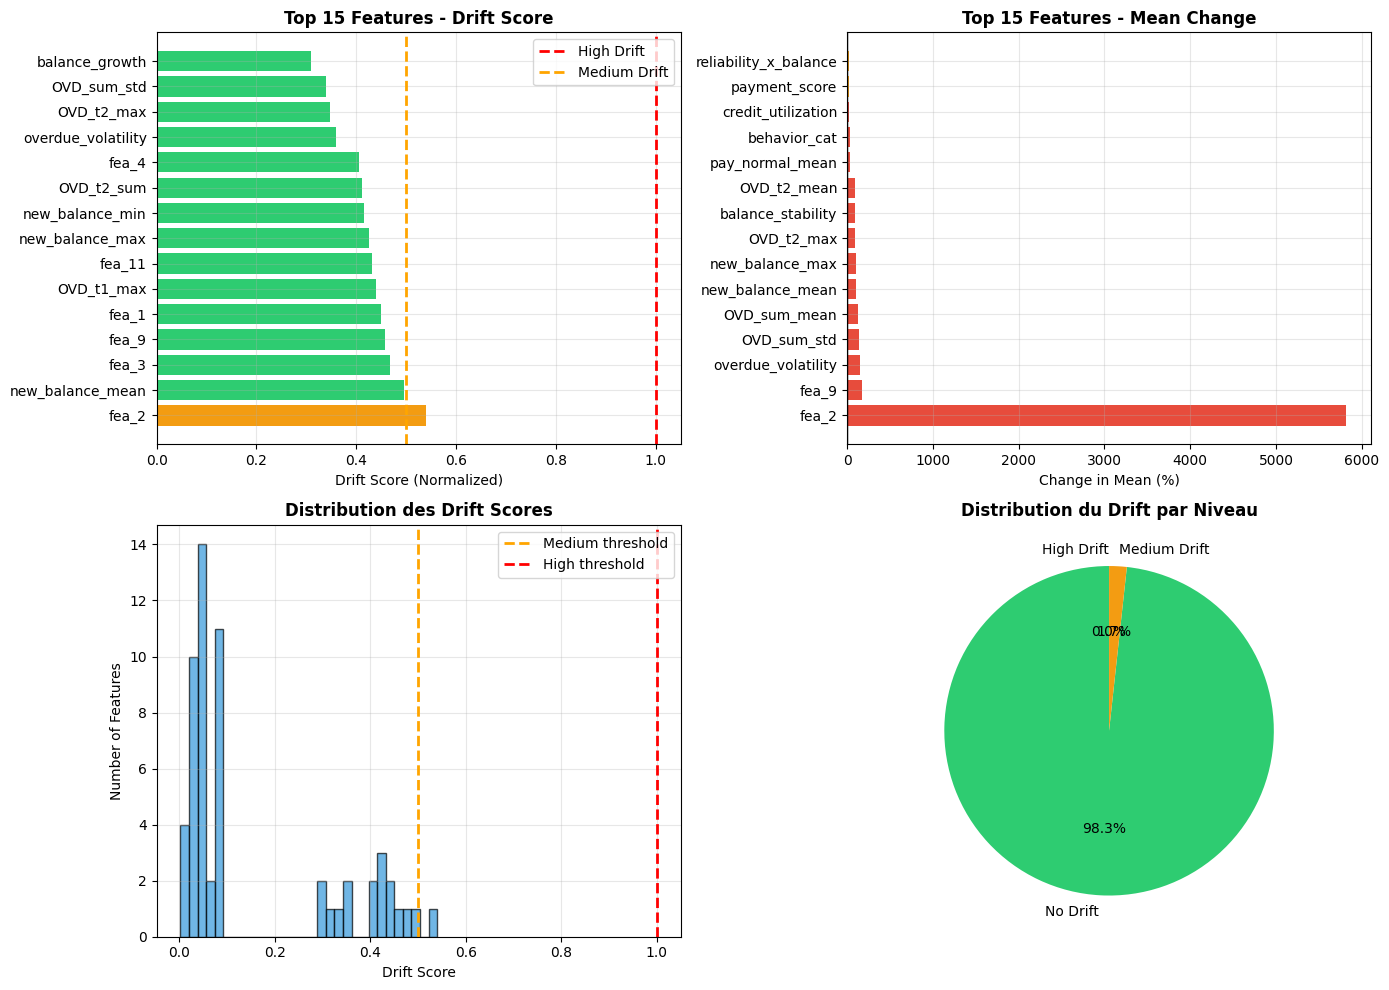

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Top features avec drift
top_drift = drift_df.head(15)
colors = ['#e74c3c' if x > 1.0 else '#f39c12' if x > 0.5 else '#2ecc71'
          for x in top_drift['Drift_Score']]
axes[0, 0].barh(top_drift['Feature'], top_drift['Drift_Score'], color=colors)
axes[0, 0].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='High Drift')
axes[0, 0].axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Medium Drift')
axes[0, 0].set_xlabel('Drift Score (Normalized)')
axes[0, 0].set_title('Top 15 Features - Drift Score', fontsize=12, weight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Changement en % de la moyenne
top_change = drift_df.nlargest(15, 'Mean_Change_%', keep='all')
colors_change = ['#e74c3c' if abs(x) > 20 else '#f39c12' if abs(x) > 10 else '#2ecc71'
                 for x in top_change['Mean_Change_%']]
axes[0, 1].barh(top_change['Feature'], top_change['Mean_Change_%'], color=colors_change)
axes[0, 1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0, 1].set_xlabel('Change in Mean (%)')
axes[0, 1].set_title('Top 15 Features - Mean Change', fontsize=12, weight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Distribution du drift score
axes[1, 0].hist(drift_df['Drift_Score'], bins=30, color='#3498db',
                edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Medium threshold')
axes[1, 0].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='High threshold')
axes[1, 0].set_xlabel('Drift Score')
axes[1, 0].set_ylabel('Number of Features')
axes[1, 0].set_title('Distribution des Drift Scores', fontsize=12, weight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Résumé du drift
drift_summary = {
    'No Drift': len(drift_df[drift_df['Drift_Score'] < 0.5]),
    'Medium Drift': len(drift_df[(drift_df['Drift_Score'] >= 0.5) & (drift_df['Drift_Score'] < 1.0)]),
    'High Drift': len(drift_df[drift_df['Drift_Score'] >= 1.0])
}
colors_pie = ['#2ecc71', '#f39c12', '#e74c3c']
axes[1, 1].pie(drift_summary.values(), labels=drift_summary.keys(),
               autopct='%1.1f%%', colors=colors_pie, startangle=90)
axes[1, 1].set_title('Distribution du Drift par Niveau', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

In [24]:
drift_df.to_csv('data_drift_report.csv', index=False)
print("\n Rapport de drift sauvegardé: data_drift_report.csv")



 Rapport de drift sauvegardé: data_drift_report.csv
